# Part 3: From Torch to Analog SNNs

In [1]:
#  --- General imports --- #
import numpy as np
import matplotlib.pyplot as plt

#  --- Torch for Training --- #
import torch
import torch.nn as nn
import torch.nn.functional as F

#  --- CrossSim for In-the-Loop Training --- #
from simulator import CrossSimParameters
from simulator.algorithms.dnn.torch.convert import from_torch, synchronize, convertible_modules

#  --- Norse for Stateful & Spiking Networks --- #
import norse

# --- Get the Dataset --- #
from spoken_data import get_loaders

from tqdm import tqdm
from pathlib import Path

2024-04-18 16:26:12.904820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 16:26:12.904872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 16:26:12.906248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 16:26:12.914470: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 16:26:14.565310: W tensorflow/compiler/tf2

In [2]:
# Define our CrossSim analog accelerator parameter set
from simulator import CrossSimParameters
from simulator.algorithms.dnn.torch.convert import from_torch

cs_params = CrossSimParameters()
cs_params.xbar.device.cell_bits = 4  # Quantized Weights
cs_params.xbar.device.programming_error.model = 'SONOS'
cs_params.xbar.device.programming_error.enable = True
cs_params.simulation.convolution.conv_matmul = True
#cs_params.xbar.adc.mvm.calibrated_range = [-1,1]
#cs_params.xbar.adc.mvm.bits = 8
#cs_params.xbar.adc.mvm.model = 'QuantizerADC'

In [3]:
# Information about network structure, which will remain the same throughout this notebook
batch_size = 32
n_channels = [1, 8, 16]
n_units = [64*n_channels[-1], 100, 10]
n_epochs = 100
retrain = False

# Create the Task
In order to capture convolutional and temporal information in the task, we utilize the free spoken digits dataset, in which an audio file has been preprocessed into the spectrogram. The spectrogram will be introduced one time-step as a time, and the task of the network is to correctly label the number *by the end* of the trial.

![](figs/fsdd.png)

Note that we will be following Norse's convention on dimensions:
(batch, time, x, y)

In [4]:
loader_train, loader_val = get_loaders(batch_size)

# Create a Rate-Based Network

In the previous notebook we demonstrated how to utilize CrossSim's `from_torch` function to convert Linear and Conv2D layers to AnalogLayers.
In the current task, we wish to create a convolutional recurrent network (CRNN), in order to address the "spatial" and temporal aspects of the data. 
Because these CRNN layers are not built into Torch or CrossSim, we first demonstrate how to compose them of simpler layers.

![](figs/crnn.png)

In [5]:
# Note: Although we are interested in a 1D convolution for the defined task, 
# a 2d is more general and the kernel size can be set to [1, N] to replicate 
# 1d convolution behavior

class ConvRNN(nn.Module):
    def __init__(self, input_size, hidden_size,
                 kernel_size, padding=None):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size

        if padding is None:
            if isinstance(kernel_size, tuple):
                padding = (self.kernel_size[0] // 2, self.kernel_size[1]//2)
            else:
                padding = self.kernel_size // 2

        self.padding = padding

        self.w_ih = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, padding=padding, bias=False)
        self.w_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, padding=padding)

    def forward(self, x, state=None):
        p1 = self.w_ih(x)
        if state is None:
            state = torch.zeros_like(p1)
        p2 = self.w_hh(state)
        state = F.tanh(p1+p2)

        return state, state

The ConvRNN module implements the overall connevitivity of the above image. There are *two* convolutional sub-modules, w_ih which takes input values and projects to the hidden state, and w_hh which takes the previous time-steps activation and reintroduces those values for the update.
The output of the ConvRNN module is based on the linear sum of feedforward and recurrent activities.
Note that due to the recurrent weights, we *must* have padding implemented such that the hidden values are the same size (eg: pixels) as the input.

In [6]:
# We next define a helper class which encapsulates the steps for running and  stateful network
class SequentialStateWrapper():
    def __init__(self, net, loss, learning_rate=1e-3, last_only=False):
        self.net = net
        self.loss = loss
        self.learning_rate = learning_rate
        self.last_only = last_only
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)

    def forward(self, x):
        if (len(x.shape) == 4):
            x = torch.unsqueeze(x, 2)
             # Note: this is not general, but a caveat of using Conv2D instead of Conv1D
        state = None
        outs = list()

        for t in range(0, x.shape[1]):
            out, state = self.net(x[:, t], state)
            outs.append(out)
        outs = torch.stack(outs, dim=1)
        return outs
    
    def training_step(self, batch):
        self.optimizer.zero_grad()

        pred = self.forward(batch[0])
        if self.last_only:
            loss = self.loss(pred[:,-1], batch[1][:,-1])
        else:
            loss = self.loss(pred, batch[1])

        loss.backward()
        self.optimizer.step()
        return loss

    def validation_step(self, batch):
        pred = self.forward(batch[0])
        if self.last_only:
            loss = self.loss(pred[:,-1], batch[1][:,-1])
        else:
            loss = self.loss(pred, batch[1])
        return loss
    
    def train_epoch(self, train_loader, val_loader):
        loss_train = 0
        for minibatch in iter(train_loader):
            loss_train += self.training_step(minibatch).detach()

        loss_val = 0
        for minibatch in iter(val_loader):
            loss_val += self.validation_step(minibatch).detach()

        return loss_train/len(train_loader), loss_val/len(val_loader)
    
    def train(self, train_loader, val_loader, epochs, name):
        loss_train = np.zeros(epochs)
        loss_val = np.zeros(epochs)

        for e in tqdm(range(0, epochs)):
            lt, lv = self.train_epoch(train_loader, val_loader)
            loss_train[e] = lt
            loss_val[e] = lv

        Path('./logs/' + name).mkdir(parents=True, exist_ok=True)
        np.save('./logs/' + name + '/loss_train', loss_train)
        np.save('./logs/' + name + '/loss_val', loss_val)
        torch.save(
            {'state_dict': self.net.state_dict()},
            './logs/' + name + '/net.pt')

        return loss_train, loss_val

In [7]:
net_pt = norse.torch.SequentialState(
    ConvRNN(n_channels[0], n_channels[1], kernel_size=3, padding=1),
    ConvRNN(n_channels[1], n_channels[2], kernel_size=3, padding=1),
    nn.Flatten(),
    nn.Linear(n_units[0], n_units[1]),
    nn.ReLU(),
    nn.Linear(n_units[1], n_units[2]),
)

model_pt = SequentialStateWrapper(net_pt, nn.CrossEntropyLoss(), last_only=True)

if retrain:
    loss_train_pt, loss_val_pt = model_pt.train(loader_train, loader_val, n_epochs, 'fsdd_pt')
else:
    loss_train_pt =  np.load('./logs/fsdd_pt/loss_train.npy')
    loss_val_pt = np.load('./logs/fsdd_pt/loss_val.npy')
    ckpt = torch.load('./logs/fsdd_pt/net.pt', map_location='cpu')
    model_pt.net.load_state_dict(ckpt['state_dict'])

# Rate-Based CrossSim Network

As with the feedforward networks, all that's required to implement a CRNN in CrossSim is to call `from_torch` and apply `synchronize` on each optimization step. 
Both of these functions will deal with nested modules, and therefore capture the convolutional layers *within* the ConvRNN

In [8]:
convertible_modules(net_pt)

[Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Linear(in_features=1024, out_features=100, bias=True),
 Linear(in_features=100, out_features=10, bias=True)]

In [9]:
class CrossSimSequentialStateWrapper(SequentialStateWrapper):
    def __init__(self, net, loss, learning_rate=1e-3, last_only=False):
        super().__init__(net, loss, learning_rate, last_only)
        
    def training_step(self, batch):
        self.optimizer.zero_grad()
        
        pred = self.forward(batch[0])
        if self.last_only:
            loss = self.loss(pred[:,-1], batch[1][:,-1])
        else:
            loss = self.loss(pred, batch[1])
        
        loss.backward()
        self.optimizer.step()
        synchronize(self.net)
        return loss


net_cs = norse.torch.SequentialState(
    ConvRNN(n_channels[0], n_channels[1], kernel_size=3, padding=1),
    ConvRNN(n_channels[1], n_channels[2], kernel_size=3, padding=1),
    nn.Flatten(),
    nn.Linear(n_units[0], n_units[1]),
    nn.ReLU(),
    nn.Linear(n_units[1], n_units[2]),
)
net_cs = from_torch(net_cs, cs_params)
model_cs = CrossSimSequentialStateWrapper(net_cs, torch.nn.CrossEntropyLoss(), last_only=True)

if retrain:
    loss_train_cs, loss_val_cs = model_cs.train(loader_train, loader_val, n_epochs, 'fsdd_cs')
else:
    loss_train_cs =  np.load('./logs/fsdd_cs/loss_train.npy')
    loss_val_cs = np.load('./logs/fsdd_cs/loss_val.npy')
    ckpt = torch.load('./logs/fsdd_cs/net.pt', map_location='cpu')
    model_cs.net.load_state_dict(ckpt['state_dict'])

# Create Spiking Network

We can utilize the same overall network architecture as above, but replace each of the units with a LIF neuron.
We implement this using the LIFBoxCell from Norse, and replace the activation function from the ConvRNN above. 

Just as AnalogLayers implement pass-through approximations for ANN operations, Norse activation functions will utilize surrogate activation functions to enable training of spiking networks.

In [10]:
class ConvSRNN(nn.Module):
    def __init__(self, input_size, hidden_size,
                 kernel_size, padding=None,
                 act = norse.torch.LIFBoxCell(norse.torch.LIFBoxParameters(tau_mem_inv = 250)),
                 ):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size

        self.act = act

        if padding is None:
            if isinstance(kernel_size, tuple):
                padding = (self.kernel_size[0] // 2, self.kernel_size[1]//2)
            else:
                padding = self.kernel_size // 2

        self.padding = padding

        self.w_ih = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, padding=padding, bias=False)
        self.w_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, padding=padding)

    def forward(self, x, state=None):
        # Note: State is now a tuple of the outputs of the neuron from the previous time step:
        # (spikes, state)

        ff = self.w_ih(x)
        if state is None:
            state = (torch.zeros_like(ff), None)
        fr = self.w_hh(state[0])
        spikes, state = self.act(ff+fr)

        return spikes, (spikes, state)

In [11]:
net_no = norse.torch.SequentialState(
    ConvSRNN(n_channels[0], n_channels[1], kernel_size=3, padding=1),
    ConvSRNN(n_channels[1], n_channels[2], kernel_size=3, padding=1),
    nn.Flatten(),
    nn.Linear(n_units[0], n_units[1]),
    norse.torch.LICell(norse.torch.LIParameters(tau_mem_inv = 250)),
    nn.Linear(n_units[1], n_units[2]),
)

#net_sp = from_torch(net_sp, cs_params)
model_no = SequentialStateWrapper(net_no, nn.CrossEntropyLoss(), last_only=True)

if retrain:
    loss_train_sp, loss_val_sp = model_sp.train(loader_train, loader_val, n_epochs, 'fsdd_no')
else:
    loss_train_no =  np.load('./logs/fsdd_no/loss_train.npy')
    loss_val_no = np.load('./logs/fsdd_no/loss_val.npy')
    ckpt = torch.load('./logs/fsdd_no/net.pt', map_location='cpu')
    model_no.net.load_state_dict(ckpt['state_dict'])    

# Spiking CrossSim Network
By utilizing LIF neurons instead of a traditional ANN activation such as hyperbolic tangent, we can drop ADC steps from our CrossSim parameters.
This is because the capacitiance of each LIF unit will directly serve to integrate electrical current from the crossbar array and translate it into voltage spikes.
This can drastically decrease energy consumption compared to eg: an 8-bit ADC scheme.

![](figs/AnalogCrossbarSpiking.png)

In [12]:
# Define our CrossSim analog accelerator parameter set
from simulator import CrossSimParameters
from simulator.algorithms.dnn.torch.convert import from_torch

cs_params = CrossSimParameters()
cs_params.xbar.device.cell_bits = 4  # Quantized Weights
cs_params.xbar.device.programming_error.model = 'SONOS'
cs_params.xbar.device.programming_error.enable = True
cs_params.simulation.convolution.conv_matmul = True

# For clarity, we show that the adc is explicitly **not** included in the spiking version.
#cs_params.xbar.adc.mvm.calibrated_range = [-1,1]
#cs_params.xbar.adc.mvm.bits = 8
#cs_params.xbar.adc.mvm.model = 'QuantizerADC'

In [21]:
net_sp = norse.torch.SequentialState(
    ConvSRNN(n_channels[0], n_channels[1], kernel_size=3, padding=1),
    ConvSRNN(n_channels[1], n_channels[2], kernel_size=3, padding=1),
    nn.Flatten(),
    nn.Linear(n_units[0], n_units[1]),
    norse.torch.LICell(norse.torch.LIParameters(tau_mem_inv = 250)),
    nn.Linear(n_units[1], n_units[2]),
)

net_sp = from_torch(net_sp, cs_params)
model_sp = CrossSimSequentialStateWrapper(net_sp, nn.CrossEntropyLoss(), last_only=True)

if retrain:
    loss_train_sp, loss_val_sp = model_sp.train(loader_train, loader_val, n_epochs, 'fsdd_sp')
else:
    loss_train_sp =  np.load('./logs/fsdd_sp/loss_train.npy')
    loss_val_sp = np.load('./logs/fsdd_sp/loss_val.npy')
    ckpt = torch.load('./logs/fsdd_sp/net.pt', map_location='cpu')
    model_sp.net.load_state_dict(ckpt['state_dict'])    

# Plots

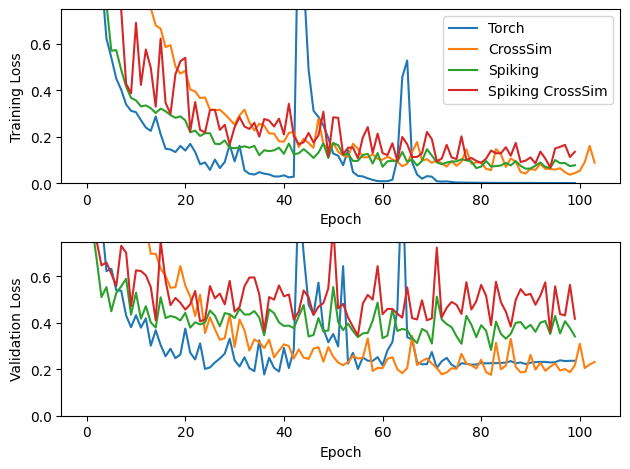

In [22]:
plt.subplot(211)
plt.plot(loss_train_pt)
plt.plot(loss_train_cs)
plt.plot(loss_train_no)
plt.plot(loss_train_sp)
plt.ylim([0, 0.75])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(['Torch','CrossSim','Spiking','Spiking CrossSim'])

plt.subplot(212)
plt.plot(loss_val_pt)
plt.plot(loss_val_cs)
plt.plot(loss_val_no)
plt.plot(loss_val_sp)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.ylim([0, 0.75])
plt.tight_layout()
#plt.legend(['Torch','CrossSim','Spiking','Spiking CrossSim'])